# Mini Projeto 3

## implementação de uma MLP usando Pytorch

Neste projeto, implementei uma Multi-Layer Perceptron (MLP) usando PyTorch para classificar a base de dados MNIST.

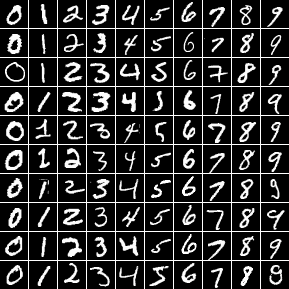

ImpoImportando todas as bibliotecas e a base de dados.

In [32]:
from torchvision import datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [33]:
# Baixar o conjunto de treinamento MNIST, nesse poonto não estou usando nenhuma transformação
batch_size = 128 
base_treinamento = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
base_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [34]:
# Carrega todos os dados
treinamento_img = torch.utils.data.DataLoader(dataset=base_treinamento, batch_size=batch_size, shuffle=True)
teste_img = torch.utils.data.DataLoader(dataset=base_test, batch_size=batch_size, shuffle=False)

Definição do MLP em Pytorch

In [35]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Implementação do modelo base de acordo com a solicitação

In [36]:
#Dados da MLP "Direto do classroom"

input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 500  # Número de neurônios na camada oculta
output_size = 10  # Número de saidas possiveis

num_epochs = 5
learning_rate = 0.001

# Definição do modelo
rede = MLP(input_size, hidden_size, output_size)

1. Inicializando o função de otimização (parametros passados no classroom)
2. Iniciando a GPU (para esse caso vou inicia-la apenas se disponivel no PC)

In [37]:
# Inicializando o atimizador

otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate)

PC_Processo = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda ativa GPU
rede.to(PC_Processo) # GPU se disponivel é ativada aqui

MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

# calculadora de acuracia

In [38]:
def calcular_acuracia(model, data_loader, PC_Processo):
    model.eval()
    corretos = 0
    total = 0
    with torch.no_grad():
        for imagens, rotulos in data_loader:
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)
            saidas = model(imagens)
            _, previstos = torch.max(saidas.data, 1)
            total += rotulos.size(0)
            corretos += (previstos == rotulos).sum().item()
    return (corretos / total) * 100  # Multiplicando por 100 para obter a porcentagem

# chegou a hora de testar o modelo na tentativa de receber dados
## para assim ver os resultados e desse modo aplicar possiveis mudanças

In [39]:
def treinar_e_avaliar(model, treinamento_loader, teste_loader, otimizador, num_epochs, PC_Processo): # função que calcula e treina minha IA (serve para facilitar minha vida em seguida)
    acuracias = []
    criterio = nn.CrossEntropyLoss()
    # Avaliação inicial
    acuracia_inicial = calcular_acuracia(model, teste_loader, PC_Processo)
    acuracias.append(acuracia_inicial)
    print(f"Acurácia inicial: {acuracia_inicial:.4f}")

    # Loop de treinamento
    for epoch in range(num_epochs):
        for i, (imagens, rotulos) in enumerate(treinamento_loader):
            imagens = imagens.view(-1, 28*28).to(PC_Processo)
            rotulos = rotulos.to(PC_Processo)

            # Forward pass
            saidas = model(imagens)
            perda = criterio(saidas, rotulos)

            # Backward pass e otimização
            otimizador.zero_grad()
            perda.backward()
            otimizador.step()

        # Avaliação no conjunto de teste (ou validação) ao final de cada época
        acuracia_epoca = calcular_acuracia(model, teste_loader, PC_Processo)
        acuracias.append(acuracia_epoca)

        # Imprimindo informações
        print(f'Época [{epoch+1}/{num_epochs}], Acurácia de Teste: {acuracia_epoca:.4f}')

    return acuracias

In [40]:
# Exemplo de uso
acuracias_treinamento = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)
valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)

Acurácia inicial: 15.2600
Época [1/5], Acurácia de Teste: 60.6100
Época [2/5], Acurácia de Teste: 68.3800
Época [3/5], Acurácia de Teste: 72.1100
Época [4/5], Acurácia de Teste: 74.9000
Época [5/5], Acurácia de Teste: 76.8100


Plot dos resultados

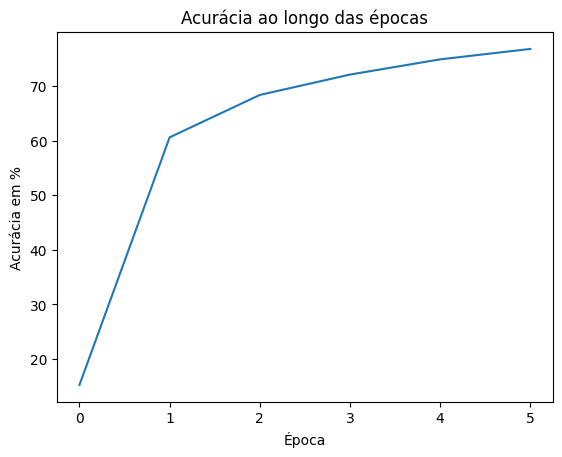

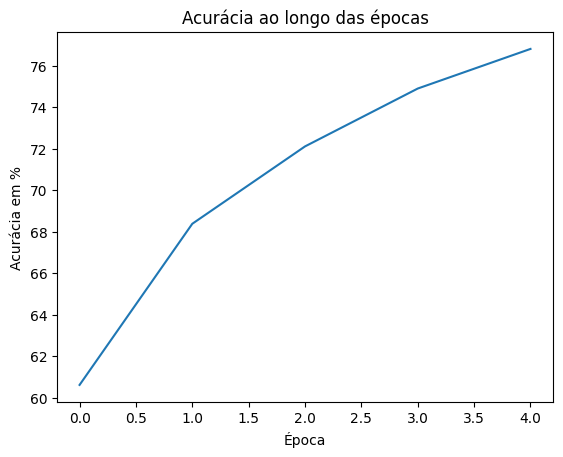

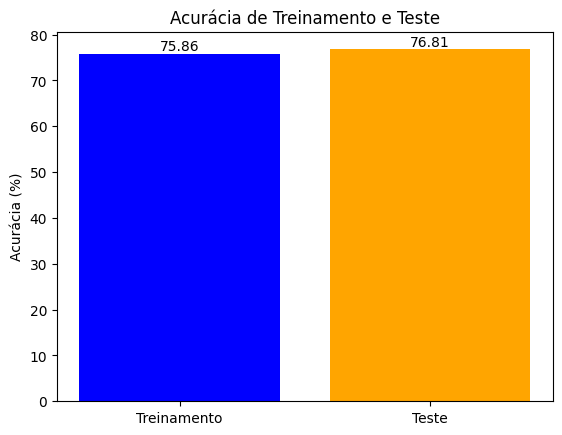

[15.260000000000002, 60.61, 68.38, 72.11, 74.9, 76.81]
[75.85666666666665, 76.81]


In [41]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento)
print([valor_treino, valor_teste])


Dado o resultado anterior percebi que que logo após a primeira interação o mesmo esta demorando muito para chegar ao melhor resultado possivel, logo resolvi almenatr o LR na tentativa de acelerar o processo alem de reduzir a complexidade da camada reduzindo o numero de neuronios

In [42]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 258  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 10
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 8.2600
Época [1/10], Acurácia de Teste: 74.3600
Época [2/10], Acurácia de Teste: 81.3600
Época [3/10], Acurácia de Teste: 84.6500
Época [4/10], Acurácia de Teste: 86.4100
Época [5/10], Acurácia de Teste: 87.5000
Época [6/10], Acurácia de Teste: 88.2900
Época [7/10], Acurácia de Teste: 88.8600
Época [8/10], Acurácia de Teste: 89.4500
Época [9/10], Acurácia de Teste: 89.7800
Época [10/10], Acurácia de Teste: 89.9900


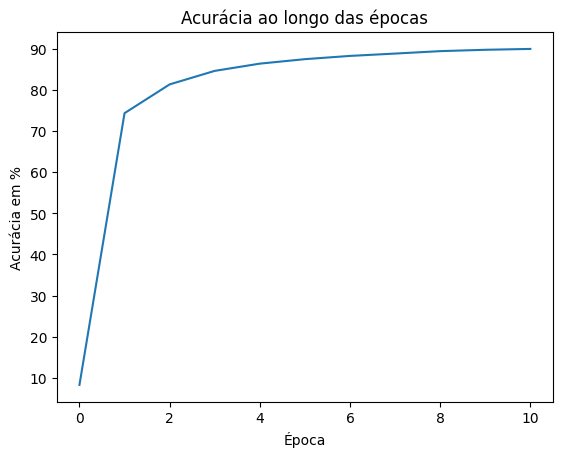

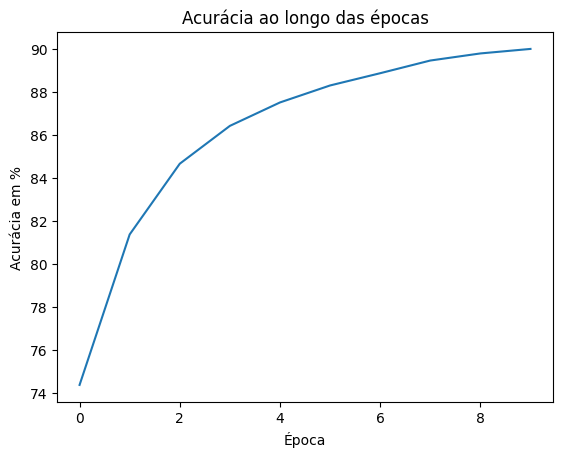

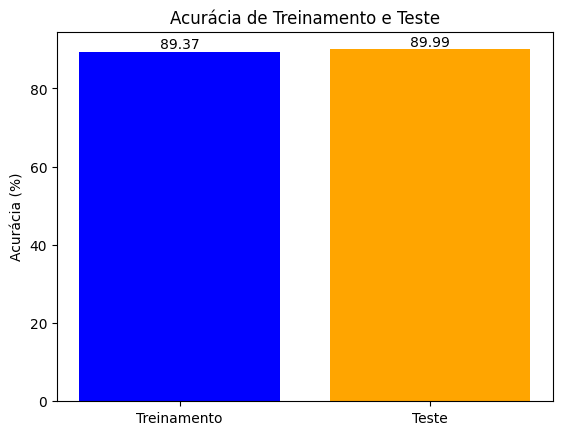

In [43]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()


Foi possivel obseravar uma grande melhora em comparação ao anterior, tambem vale a pena observar que não é um problema nem de underfitting ou overfitting ja que os dados quando comparados treino e teste são quanse identicos.

Em seguida reamais uma redução na camada oculta, para reduzir a complexidade.

In [48]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 120  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 15
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 10.4500
Época [1/15], Acurácia de Teste: 42.4500
Época [2/15], Acurácia de Teste: 61.7400
Época [3/15], Acurácia de Teste: 74.7200
Época [4/15], Acurácia de Teste: 80.6100
Época [5/15], Acurácia de Teste: 84.2500
Época [6/15], Acurácia de Teste: 86.5000
Época [7/15], Acurácia de Teste: 87.7600
Época [8/15], Acurácia de Teste: 88.5400
Época [9/15], Acurácia de Teste: 88.8200
Época [10/15], Acurácia de Teste: 89.4100
Época [11/15], Acurácia de Teste: 89.8000
Época [12/15], Acurácia de Teste: 90.2300
Época [13/15], Acurácia de Teste: 90.3200
Época [14/15], Acurácia de Teste: 90.4700
Época [15/15], Acurácia de Teste: 90.8100


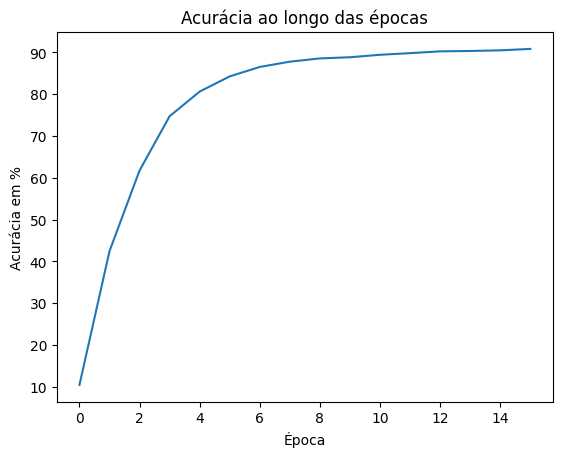

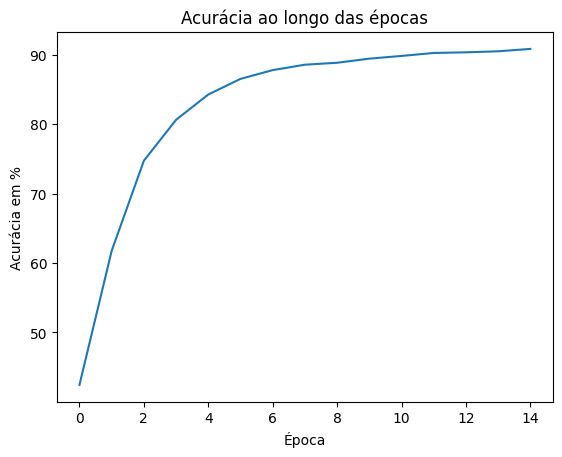

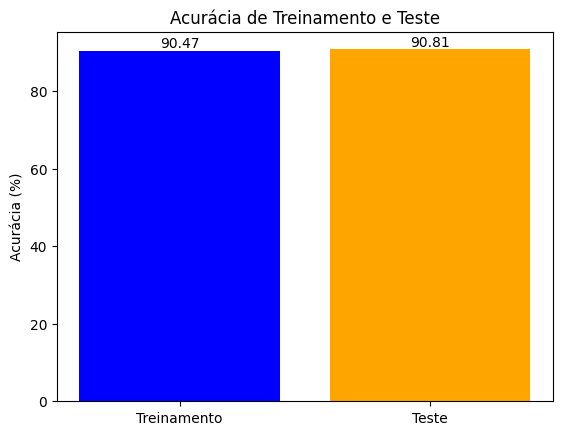

[10.45, 42.449999999999996, 61.739999999999995, 74.72, 80.61, 84.25, 86.5, 87.76, 88.53999999999999, 88.82, 89.41, 89.8, 90.23, 90.32, 90.47, 90.81]
[90.46833333333333, 90.81]


In [50]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


É perceptível que não houve muita diferença, logo irei realizar mais um teste, manter o LR já que parece estável além de aumentar o número de episódios já que o crescimento ainda se mostra bem evidente e contínuo epor fim almentar a camada interna ja que os resultados parecem levemente menores.

In [51]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 150  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 25
batch_size = 128 
learning_rate = 0.005

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 8.9900
Época [1/25], Acurácia de Teste: 59.4700
Época [2/25], Acurácia de Teste: 63.3300
Época [3/25], Acurácia de Teste: 75.9400
Época [4/25], Acurácia de Teste: 82.6800
Época [5/25], Acurácia de Teste: 85.5400
Época [6/25], Acurácia de Teste: 87.0700
Época [7/25], Acurácia de Teste: 88.0300
Época [8/25], Acurácia de Teste: 88.7700
Época [9/25], Acurácia de Teste: 89.4000
Época [10/25], Acurácia de Teste: 89.6900
Época [11/25], Acurácia de Teste: 90.0800
Época [12/25], Acurácia de Teste: 90.1900
Época [13/25], Acurácia de Teste: 90.6000
Época [14/25], Acurácia de Teste: 90.8100
Época [15/25], Acurácia de Teste: 91.0100
Época [16/25], Acurácia de Teste: 91.2100
Época [17/25], Acurácia de Teste: 91.4500
Época [18/25], Acurácia de Teste: 91.6500
Época [19/25], Acurácia de Teste: 91.8200
Época [20/25], Acurácia de Teste: 91.9000
Época [21/25], Acurácia de Teste: 92.0800
Época [22/25], Acurácia de Teste: 92.3100
Época [23/25], Acurácia de Teste: 92.2900
Época [24/25], Acu

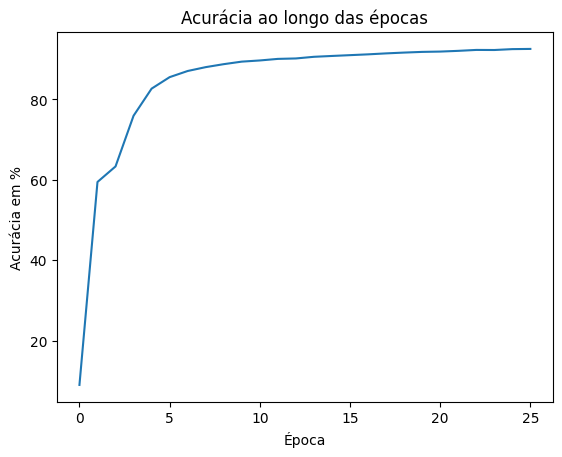

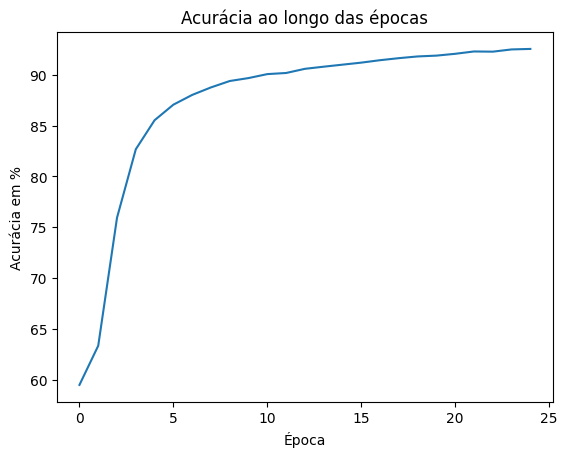

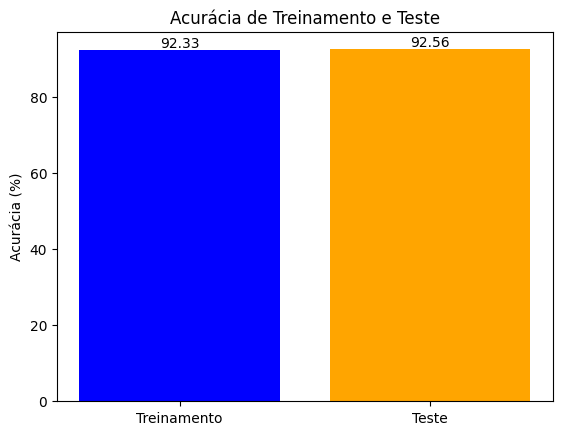

[8.99, 59.47, 63.33, 75.94, 82.67999999999999, 85.54, 87.07000000000001, 88.03, 88.77000000000001, 89.4, 89.69, 90.08, 90.19, 90.60000000000001, 90.81, 91.01, 91.21000000000001, 91.45, 91.64999999999999, 91.82000000000001, 91.9, 92.08, 92.31, 92.29, 92.51, 92.56]
[92.32833333333333, 92.56]


In [52]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


In [53]:
# Novos dados
input_size = 784  # Tamanho da entrada para o MNIST
hidden_size = 150  # Número de neurônios na camada oculta
output_size = 10  # Número de saídas possíveis

num_epochs = 25
batch_size = 128 
learning_rate = 0.01

rede = MLP(input_size, hidden_size, output_size)
otimizador = torch.optim.SGD(rede.parameters(), lr=learning_rate) # atualizando o novo LR
acuracias_treinamento2 = treinar_e_avaliar(rede, treinamento_img, teste_img, otimizador, num_epochs, PC_Processo)

valor_treino = calcular_acuracia(rede, treinamento_img, PC_Processo)
valor_teste = calcular_acuracia(rede, teste_img, PC_Processo)


Acurácia inicial: 9.2700
Época [1/25], Acurácia de Teste: 60.3400
Época [2/25], Acurácia de Teste: 81.4100
Época [3/25], Acurácia de Teste: 86.0400
Época [4/25], Acurácia de Teste: 88.5200
Época [5/25], Acurácia de Teste: 89.5900
Época [6/25], Acurácia de Teste: 90.2700
Época [7/25], Acurácia de Teste: 90.7700
Época [8/25], Acurácia de Teste: 91.1300
Época [9/25], Acurácia de Teste: 91.5200
Época [10/25], Acurácia de Teste: 91.7500
Época [11/25], Acurácia de Teste: 92.1300
Época [12/25], Acurácia de Teste: 92.3600
Época [13/25], Acurácia de Teste: 92.6300
Época [14/25], Acurácia de Teste: 92.8200
Época [15/25], Acurácia de Teste: 92.9700
Época [16/25], Acurácia de Teste: 93.0600
Época [17/25], Acurácia de Teste: 93.3000
Época [18/25], Acurácia de Teste: 93.5500
Época [19/25], Acurácia de Teste: 93.6200
Época [20/25], Acurácia de Teste: 93.6900
Época [21/25], Acurácia de Teste: 93.8800
Época [22/25], Acurácia de Teste: 94.0100
Época [23/25], Acurácia de Teste: 94.1400
Época [24/25], Acu

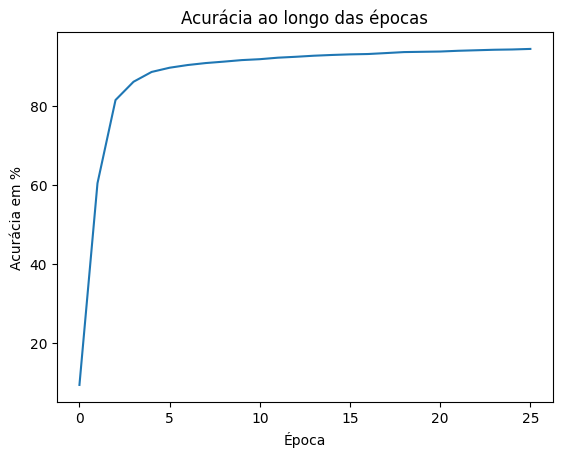

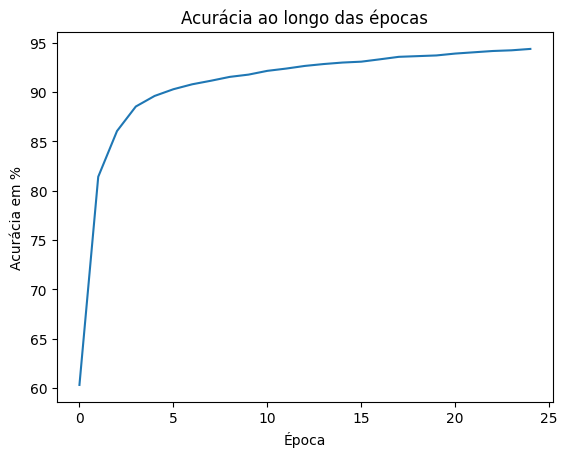

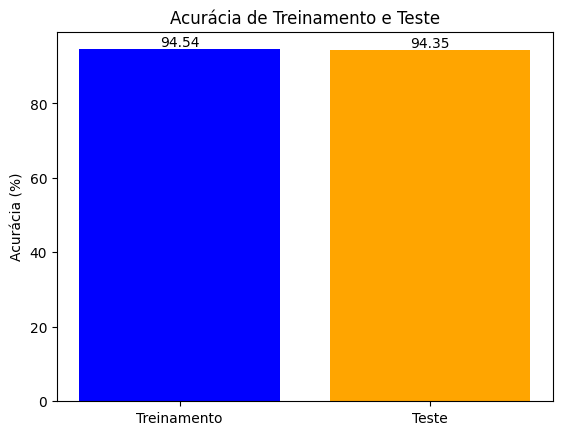

[9.27, 60.34, 81.41000000000001, 86.04, 88.52, 89.59, 90.27, 90.77, 91.13, 91.52, 91.75, 92.13, 92.36, 92.63, 92.82000000000001, 92.97, 93.06, 93.30000000000001, 93.55, 93.62, 93.69, 93.88, 94.01, 94.14, 94.21000000000001, 94.35]
[94.53666666666666, 94.35]


In [54]:
# Plotando a acurácia ao longo das épocas
plt.plot(acuracias_treinamento2[:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Plotando a acurácia ao longo das épocas sem o 1º valor (antes de iniciar o treino)
plt.plot(acuracias_treinamento2[1:])
plt.title('Acurácia ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia em %')
plt.show()

# Criar um gráfico de barras
categorias = ['Treinamento', 'Teste']
valores = [valor_treino, valor_teste]

fig, ax = plt.subplots()
barras = ax.bar(categorias, valores, color=['blue', 'orange'])
plt.ylabel('Acurácia (%)')
plt.title('Acurácia de Treinamento e Teste')

# Adicionar os valores acima das barras
for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.show()

print(acuracias_treinamento2)
print([valor_treino, valor_teste])


# Nota final

Fica notavel que apesar de o modelo melhorar a cada epsodio o mesmo esta melhorando de forma bem linear

[94.53666666666666, 94.35] # valores de acuracia de treino e teste respectivamente

